In [204]:
import quimb.tensor as qtn
import quimb as qu

import netket as nk
from vmc_torch.hamiltonian import spin_Heisenberg_square_lattice
import numpy as np
from math import pi
from autoray import do

ndim = 2
Lx = 4
Ly = 4
L = 4
pbc = False
total_sz = 0.0
print(f"Total Sz = {total_sz}")
D = 2

# Build square lattice with nearest and next-nearest neighbor edges
# lattice = nk.graph.Square(L, max_neighbor_order=1, pbc=False)
# g = lattice = nk.graph.Hypercube(L, ndim, pbc=pbc)
g = lattice = nk.graph.Grid([Lx, Ly], pbc=pbc)
# g = lattice = nk.graph.Pyrochlore([L, L, L], pbc=pbc)

n = lattice.n_nodes
hi = nk.hilbert.Spin(s=1 / 2, total_sz=0.0, N=n)
# Heisenberg with coupling J=1.0 for nearest neighbors
# and J=0.5 for next-nearest neighbors
# H = nk.operator.Ising(hilbert=hi, graph=lattice, J=1.0, h=1.0)
H = nk.operator.Heisenberg(hilbert=hi, graph=lattice, J=1.0, sign_rule=False) # In Netket, the spin operators are Pauli matrices, while in Quimb they are 1/2*Pauli matrices

ham0 = spin_Heisenberg_square_lattice(L, J=1.0, pbc=pbc,total_sz=total_sz)
hi0 = ham0.hilbert

Total Sz = 0.0


In [205]:
# compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
evals = nk.exact.lanczos_ed(H, compute_eigenvectors=False)
exact_gs_energy = evals[0]
print('The exact ground-state energy is E0=',exact_gs_energy)
print(exact_gs_energy/(Lx*Ly)/4)

The exact ground-state energy is E0= -36.756828260771854
-0.5743254415745602


In [206]:
# PEPS tensor network
psi = qtn.PEPS.rand(Lx=Lx, Ly=Ly, bond_dim=D, phys_dim=2) # initialization from PEPS
J=1.0
ham = qtn.ham_2d_heis(Lx=Lx, Ly=Ly, j=J*4)
su = qtn.tensor_arbgeom_tebd.SimpleUpdateGen(
    psi, 
    ham,
    compute_energy_every=10,
    compute_energy_per_site=True,
)
for tau in [1.0, 0.3, 0.1, 0.03, 0.01]:
    su.evolve(100, tau=tau)
psi_su = su.state

peps = su.get_state()
peps.equalize_norms_(value=1)

# save the state
params, skeleton = qtn.pack(peps)

import os
import pickle
os.makedirs(f'../../data/{Lx}x{Ly}/J={J}/D={D}', exist_ok=True)

with open(f'../../data/{Lx}x{Ly}/J={J}/D={D}/peps_skeleton.pkl', 'wb') as f:
    pickle.dump(skeleton, f)
with open(f'../../data/{Lx}x{Ly}/J={J}/D={D}/peps_su_params.pkl', 'wb') as f:
    pickle.dump(params, f)
    

n=500, tau=0.0100, energy~-2.108514: 100%|##########| 100/100 [00:01<00:00, 69.55it/s]


In [189]:
def from_netket_to_quimb_spin_config(config):
    """From (-1,1) to (0,1) basis"""
    def func(x):
        return do('array',(x + 1) / 2, dtype=int)
    if len(config.shape) == 1:
        return func(config)
    else:
        return np.array([func(c) for c in config])

def get_amp(psi, config):
    return psi.isel({psi.site_inds[i]: int(s) for i, s in enumerate(config)})

def to_array(psi):
    return psi.to_dense()

def to_array_amps(psi, configs_netket):
    configs = from_netket_to_quimb_spin_config(configs_netket)
    return np.array([get_amp(psi, config).contract() for config in configs])

def to_array_config_dict(psi, configs_netket):
    configs = from_netket_to_quimb_spin_config(configs_netket)
    return {tuple(config): get_amp(psi, config).contract() for config in configs}

In [190]:
psi_vec = to_array_amps(psi_su, hi.all_states())
# psi_dict = to_array_config_dict(psi_su, hi.all_states())

In [192]:
hamiltonian = H.to_dense()

print("Energy from Quimb:", np.vdot(psi_vec, hamiltonian @ psi_vec).real / np.vdot(psi_vec, psi_vec).real/(Lx*Ly)/4)

Energy from Quimb: -0.528558043149109


In [193]:
# psi_su.view_as_(qtn.PEPS)
psi_su.compute_local_expectation(ham.terms, normalized=True, max_bond=128)/(Lx*Ly)/4

-0.49680707385756656

In [153]:
import numpy as np
from quimb.utils import progbar as Progbar
from mpi4py import MPI
import pickle
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

# torch
from torch.nn.parameter import Parameter
import torch
import torch.nn as nn
torch.autograd.set_detect_anomaly(False)

# quimb
import quimb as qu
import quimb.tensor as qtn
import autoray as ar
from autoray import do

from vmc_torch.experiment.tn_model import PEPS_model, PEPS_NN_Model, init_weights_to_zero, PEPS_NNproj_Model
from vmc_torch.sampler import MetropolisExchangeSamplerSpinless, MetropolisExchangeSamplerSpinful
from vmc_torch.variational_state import Variational_State
from vmc_torch.optimizer import TrivialPreconditioner, SignedSGD, SGD, SR
from vmc_torch.VMC import VMC
from vmc_torch.hamiltonian import square_lattice_spin_Heisenberg, spin_Heisenberg_square_lattice
from vmc_torch.torch_utils import SVD,QR

# Register safe SVD and QR functions to torch
ar.register_function('torch','linalg.svd',SVD.apply)
ar.register_function('torch','linalg.qr',QR.apply)

from vmc_torch.global_var import DEBUG


COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Hamiltonian parameters
J = 1.0
# H, hi, graph = square_lattice_spinful_Fermi_Hubbard(Lx, Ly, t, U, N_f)
H = spin_Heisenberg_square_lattice(L, J, total_sz=0.0)
graph = H.graph
# TN parameters
D = 2
chi = -1
dtype=torch.float64

# Load PEPS
skeleton = pickle.load(open(f"../../data/{L}x{L}/J={J}/D={D}/peps_skeleton.pkl", "rb"))
peps_params = pickle.load(open(f"../../data/{L}x{L}/J={J}/D={D}/peps_su_params.pkl", "rb"))
peps = qtn.unpack(peps_params, skeleton)
peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=dtype))

# VMC sample size
N_samples = 2**10
N_samples = N_samples - N_samples % SIZE + SIZE
if (N_samples/SIZE)%2 != 0:
    N_samples += SIZE

model = PEPS_model(peps, max_bond=None)
# model = PEPS_NN_Model(peps, max_bond=chi, nn_eta=1.0, nn_hidden_dim=L**2)
# model = PEPS_NNproj_Model(peps, max_bond=chi, nn_eta=1.0, nn_hidden_dim=L**2)
# model.apply(init_weights_to_zero)
model_names = {
    PEPS_model: 'PEPS',
    PEPS_NN_Model: 'PEPS_NN',
    PEPS_NNproj_Model: 'PEPS_NNproj'
}
model_name = model_names.get(type(model), 'UnknownModel')

init_step = 0
total_steps = 200
if init_step != 0:
    saved_model_params = torch.load(f'../../data/{L}x{L}/J={J}/D={D}/{model_name}/chi={chi}/model_params_step{init_step}.pth')
    saved_model_state_dict = saved_model_params['model_state_dict']
    saved_model_params_vec = torch.tensor(saved_model_params['model_params_vec'])
    try:
        model.load_state_dict(saved_model_state_dict)
    except:
        model.load_params(saved_model_params_vec)

# optimizer = SignedSGD(learning_rate=0.05)
optimizer = SGD(learning_rate=0.05)
sampler = MetropolisExchangeSamplerSpinless(H.hilbert, graph, N_samples=N_samples, burn_in_steps=20, reset_chain=False, random_edge=False, dtype=dtype)
variational_state = Variational_State(model, hi=H.hilbert, sampler=sampler, dtype=dtype)
preconditioner = SR(dense=False, exact=True if sampler is None else False, use_MPI4Solver=True, diag_eta=0.05, iter_step=1e5, dtype=dtype)
vmc = VMC(H, variational_state, optimizer, preconditioner)


In [161]:
batchsize = 500
# samples = sampler.sample(H, variational_state, chain_length=batchsize)
# samples[0]/batchsize/L**2/4
samples = sampler.sample_expectation(variational_state, H, chain_length=batchsize)

In [170]:
O_loc = np.asarray(samples[1])/L**2/4
samples[0]/L**2/4

np.float64(-0.49400048802251967)

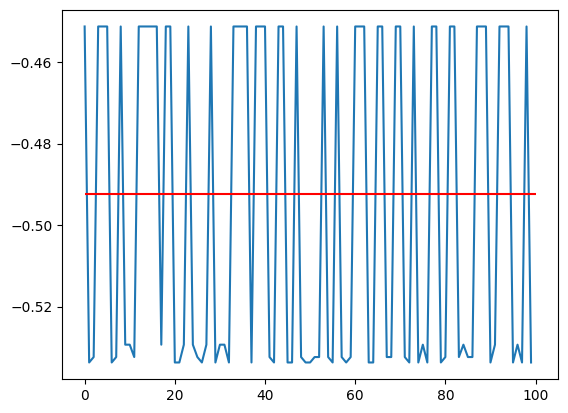

In [168]:
import matplotlib.pyplot as plt
plt.plot(O_locs[:100])
plt.hlines(np.mean(O_locs), 0, 100, colors='r')